The following code is inspired by:
- https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network2.py
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://beckernick.github.io/neural-network-scratch/

##  Simple Neural Network

I will build a neural network from scatch to familarize myself with the inner details. I will use train the neural network to classify randomly generated data. 

#### Network Architecture
The network has three layers: an inpute layer, a hidden layer with ReLU activation nodes, and a softmax output layer. The loss of the network is computed using the cross entropy cost function.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

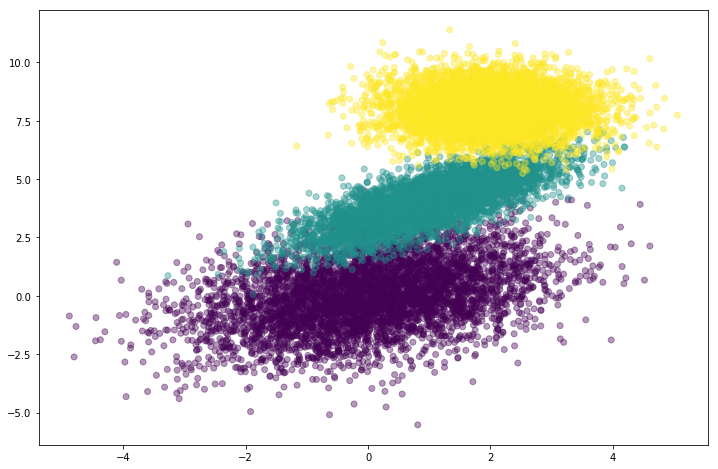

In [1]:
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[0, .75],[.75, 0]], num_observations)

simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations), np.ones(num_observations), np.ones(num_observations) + 1))

plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)



In [2]:
labels_onehot = np.zeros((simulated_labels.shape[0], 3)).astype(int)
labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1

X, X_test, \
Y, Y_test = train_test_split(
    simulated_separableish_features, labels_onehot, test_size = .1, random_state = 12)

In [13]:
X.shape

(13500, 2)

We begin by creating functions for the different functions we use in the network.
#### Definitions

- The ReLU activation function is defined as: $f(x) = \max(0, x)$
- The softmax function is defined as: $y_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$
- The Cross Entropy Cost Function is defined as: $C = - \sum_j t_j \log{y_j}$  where $t_j$ is the target value and $y_j$ is the predicted value. 

In [3]:
# Cross Entropy Cost Function
def crossEntropyCost(pred, target):
    indices = np.argmax(target, axis = 1).astype(int)
    predicted_probability = pred[np.arange(len(pred)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

#softmax
def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims = True)
    return np.exp(z) / np.sum(np.exp(z))

# ReLU activation
def activation(z):
    return np.maximum(z, 0)

### Notation
- Let $W^{(l)}_{ij}$ denote the weight associated with the connection between unit $j$ in layer $l$, and unit $i$ in layer $l+1$.
- Let $b^{(l)}_{i}$ be the bias associated with unit $i$ in layer $l+1$.

Initalize the inital bias matricies for both layers to be zero. Use a normal distribution to generate the inital random weights. 

In [15]:
hidden_nodes = 5
num_labels = Y.shape[1]
num_features = X.shape[1]
learning_rate = .01
reg_lambda = .01

# Weights and Bias 
layer1_weights = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_bias = np.zeros((1, hidden_nodes))
layer2_bias = np.zeros((1, num_labels))


In [16]:
print(layer1_weights)
print(layer1_weights.shape)
type(layer1_weights)

[[-1.03474064 -1.30456753 -1.88037667 -1.42810511  0.02789435]
 [-0.74551773  0.05918068  0.42489937 -0.63182208  0.23481791]]
(2, 5)


numpy.ndarray

### Forward Propgation
The process of forward propgation is as follows:
$$\begin{align}
a^{(1)} &= x \\
z^{(2)} &= W^{(1)} a^{(1)} + b^{(1)} \\
a^{(2)} &= \text{relu}(z^{(2)}) \\
z^{(3)} &= W^{(2)} a^{(2)} + b^{(2)} \\
a^{(3)} &= \text{softmax}(z^{(3)})
\end{align}$$

where $x$ is the input to the network, $a^{(3)}$ is the output of the network and the value used by the cost function. 

```
#forward propagate
z1 = np.dot(layer1_weights, input) + layer1_bias #inpyt = a1
hidden_output = activation(z1) # hidden_ouput = a2
z2 = np.dot(layer2_weights, hidden_output,) + layer2_bias
output = softmax(z2) # output = a3
```

### Backward Propgation
Backpropgation is the algorithmn for updating the weights so that they are better fit the training examples. 

The inuitive idea is that you use a cost function to determine the error between the predicted values and the actual values. The purpose is to minimize this error as much as possible. To do this, you can find the partial derivative of the cost in terms of each weight and bias parameter. Then you subtract the partial derivative from the weights. 

(In calculus terms, you can find the gradient of the network. Since the gradient always points in the direction of greatest rate of change, when you subtract the gradient from the parameters you are taking a step in the direction that will lead to the greatest change in the error function.)

After multiple iterations of forward and backward propgation, your weights and biases will be optimized to have a low cost function and thus higher accurcy. 

When you look at forward prop, notice how its series of composite functions with outputs of one layer being used in the inputs of the next layer. The process of finiding partial derivatives is an application of the chain rule - where you unravel each layer, chaining the partial derivatives again untill you find the partial derivative in terms of the cost.  

To begin, define $\delta^{(L)}_i$ as  
$$\begin{align}
\delta^{(L)}_i
= \frac{\partial}{\partial z^{(L)}_i} \;\;
- \sum_j t_j \log{y_j} = (a^{(L)}_i) - y_{i}
\end{align}$$

Think of $\delta^{(L)}_i$ as defining is the error for the last layer (in this case $L = 3$) in terms of its input $z^{(L)}_i$ ([see math details](http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/)). 

Then you can find the partial deriative of $W^{(2)}$ using
$$ \frac{\partial C}{\partial W^{(2)}_{ij}}  = \frac{\partial C}{\partial z^{(L)}_i} \cdot \frac{\partial z^{(L)}_i}{\partial W^{(2)}_{ij}} = a^{(2)}_j\delta^{(3)}_i $$

Similarly, you can find the partial derivative of  $b^{(2)}$ using 
$$ \frac{\partial C}{\partial b^{(2)}_{i}}  = \frac{\partial C}{\partial z^{(L)}_i} \cdot \frac{\partial z^{(L)}_i}{\partial b^{(2)}_{i}} = \delta^{(3)}_i $$


Finding the weights for $W^{(1)}$ follows a similar process ( ie find $\delta^{(2)}$ and use that to find the partial derivatives in terms of the weight). To find $\delta^{(2)}$ you apply the ... chain rule!

$$
\delta^2_j  =  \frac{\partial C}{\partial z^2_j} 
   =  \sum_k \frac{\partial C}{\partial z^{3}_k} \frac{\partial z^{3}_k}{\partial z^2_j} 
  =  \sum_k \frac{\partial z^{3}_k}{\partial z^2_j} \delta^{3}_k,
$$

Since
$$z^{3}_k = \sum_j w^{2}_{kj} a^2_j +b^{2}_k = \sum_j w^{2}_{kj} \text{relu'}(z^2_j) +b^{2}_k.
$$ 

then we can find :$$\frac{\partial z^{3}_k}{\partial z^2_j} = w^{2}_{kj} \text{relu'}(z^l_j)$$

and so $$\delta^2_j = \sum_k w^{2}_{kj}  \delta^{3}_k \text{relu'}(z^2_j).$$

You keep following a similar process for any extra hidden layers you add. 

```
#backpropagate and compute gradients (check for matrix mult alignment proper)
delta_output = output - labels
gradient_layer2_weights = np.dot(hidden_output, delta_output)
gradient_layer2_bias = delta_output

delta_hidden =  np.dot(detla_output, layer2_weights)
delta_hidden[hidden_output <= 0] = 0

gradient_layer1_weights = np.dot(input, delta_hidden)
gradient_layer1_bias = delta_hidden

# update (add or subtract)
layer1_weights -= learning_rate * gradient_layer1_weights
layer1_biases -= learning_rate * gradient_layer1_bias

layer2_weights -= learning_rate * gradient_layer2_weights
layer2_biases -= learning_rate * gradient_layer2_bias
```

In [19]:
#code with mini-batch
num_epoch = 5
for step in range(10000):
        z1 = np.dot(X, layer1_weights) #inpyt = a1
        hidden_output = activation(z1 + layer1_bias) # hidden_ouput = a2
        z2 = np.dot(hidden_output, layer2_weights) + layer2_bias
        output = softmax(z2) # output = a3
        
        
        #backpropagate and compute gradients (check for matrix mult alignment proper)
        delta_output = (output - Y) / output.shape[0]
        gradient_layer2_weights = np.dot(hidden_output.T, delta_output)
        gradient_layer2_bias = np.sum(delta_output, axis = 0, keepdims = True)
       
    
        delta_hidden =  np.dot(delta_output, layer2_weights.T)
        delta_hidden[hidden_output <= 0] = 0
        gradient_layer1_weights = np.dot(X.T, delta_hidden)        
        gradient_layer1_bias = np.sum(delta_hidden,  axis = 0, keepdims = True)
        
        
        # update (add or subtract)
        layer1_weights -= learning_rate * gradient_layer1_weights
        layer1_bias -= learning_rate * gradient_layer1_bias
        layer2_weights -= learning_rate * gradient_layer2_weights
        layer2_bias -= learning_rate * gradient_layer2_bias
        if(step % 1000 == 0):
            print(crossEntropyCost(output, Y))


0.341455810324
0.27993062128
0.242103627967
0.21680500651
0.198654030801
0.185017118262
0.174369172857
0.165792070634
0.158494274426
0.152156818384


In [20]:
def predict():
    z1 = np.dot(X_test, layer1_weights)+ layer1_bias #inpyt = a1
    hidden_output = activation(z1) # hidden_ouput = a2
    z2 = np.dot(hidden_output, layer2_weights) + layer2_bias
    output = softmax(z2) # output = a3
    return output
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy
accuracy(predict(), Y_test)

96.066666666666663